### Initialization

In [1]:
"A simulation of the detection of supernova neutrinos assuming coherent conversion on a turbulent magnetic field"
%load_ext autoreload
%autoreload 2
%autosave 0
import os
import re
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import ternary
import alphashape
import descartes
import numpy as np
import numpy.random as rnd
from scipy import special, integrate, optimize, interpolate
from moment import *

# Directories
base_dir = os.path.expanduser("~/Dropbox/mm-astro/ew/python/")
os.chdir(base_dir)

# set up matplotlib
%matplotlib inline
matplotlib.rcParams['text.usetex']    = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amssymb}'
matplotlib.rcParams['font.family']    = 'serif'
matplotlib.rcParams['font.size']      = '18'
matplotlib.rcParams['figure.figsize'] = 6.4, 4.8


# Emission data from simulation. Col 0: time in s, col 1:luminosity in 1e51 ergs,
# col 2: average energy in MeV, col 3: alpha parameter"
nu_e = np.loadtxt('sn-data/Sf/neutrino_signal_nu_e', usecols=(0,1,2,5)).transpose()
nubar_e = np.loadtxt('sn-data/Sf/neutrino_signal_nubar_e', usecols=(0,1,2,5)).transpose()
nu_x = np.loadtxt('sn-data/Sf/neutrino_signal_nu_x', usecols=(0,1,2,5)).transpose()

# Neutrino mixing parameters - NuFit 5.1, normal ordering
theta12 = 33.44 * np.pi/180.
theta13 =  8.57 * np.pi/180.
theta23 = 49.2  * np.pi/180.
m21 = 7.42e-5
m31 = 2.515e-3
m_nh = [0, np.sqrt(m21), np.sqrt(m31)]
m_ih = [np.sqrt(m31), np.sqrt(m31+m21), 0]

# error on neutrino mixing parameters
d_theta12 = 0.76 * np.pi/180.
d_theta13 = 0.13 * np.pi/180.
d_theta23 = 1.2  * np.pi/180.
d_m21     = 0.21e-5
d_m31     = 0.028e-3

# unit conversion
MeV = 1e6
GeV = 1e9
TeV = 1e12
PeV = 1e15

# chi_thrs = 4.60517    #Chi-square threshold for 90% confidence for 2 dof
chi_thrs = 2.71    #Chi-square threshold for 90% confidence for 2 dof

U = PMNS(theta12, theta13, theta23)    # PMNS matrix

muc = 1e-13*mu_b    #scaling of magnetic moment

# flavor structures of flavor-universal and muon-only magnetic moments
M_all_flavors = np.array([[1,0,0],[0,1,0],[0,0,1]])
M_mu_only     = np.array([[0,0,0],[0,1,0],[0,0,0]])

t = nu_e[0]

thrs = 3    #Detection threshold in MeV

n_e_HK = 374e9*mol*10/18    #Number of target electrons/protons in HK
n_O_HK = 374e9*mol/18    #Number of target oxygen atoms in HK
n_ar_DN = 40e9*mol/39.95    #number of target Argon atoms in DUNE
n_e_DN = 40e9*mol*18/39.95    #number of target electrons in DUNE

file_muN = open('nu_mu_limit_NO.txt', 'a')
file_muI = open('nu_mu_limit_IO.txt', 'a')
file_nusN = open('nus_limit_NO.txt', 'a')
file_nusI = open('nus_limit_IO.txt', 'a')

Autosave disabled


### preparation / tests of the neutrino_propagator class

In [215]:
# extract SnowGLoBES cross-sections
xs = np.loadtxt('/Users/jkopp/Dropbox/mm-astro/to/cross_sections/snowglobes/xs_ibd.dat')
np.savetxt('cross_sections/IBD.csv', np.array([1e3*10**xs[:,0], 1e-38*xs[:,4] * 10**xs[:,0]]).T,
           header='E [MeV]   \sigma [cm^2]')

xs = np.loadtxt('/Users/jkopp/Dropbox/mm-astro/to/cross_sections/snowglobes/xs_nue_O16.dat')
np.savetxt('cross_sections/nu_e_O.csv', np.array([1e3*10**xs[:,0], 1e-38*xs[:,1] * 10**xs[:,0]]).T,
           header='E [MeV]   \sigma [cm^2]')

xs = np.loadtxt('/Users/jkopp/Dropbox/mm-astro/to/cross_sections/snowglobes/xs_nuebar_O16.dat')
np.savetxt('cross_sections/nubar_e_O.csv', np.array([1e3*10**xs[:,0], 1e-38*xs[:,1] * 10**xs[:,0]]).T,
           header='E [MeV]   \sigma [cm^2]')

In [566]:
189/135. * 5 # 135 pixels in fig. 4 of https://arxiv.org/abs/0704.0458 correspond to 5 kpc

7.0

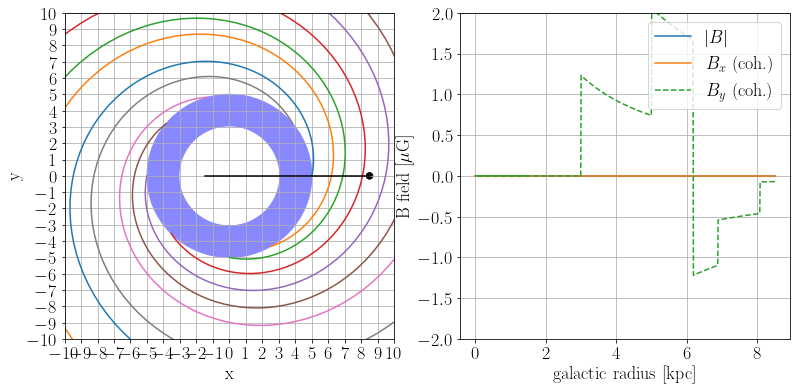

In [3]:
p = neutrino_propagator()
p.generate_B_field_gal(plot=True)

### Supernova Neutrinos – Rate Plots

In [822]:
# compute event rates
mu0       = 5e-13 * mu_b             # magnetic moment
l0        = 0.01                     # nominal outer turbulence scale [kpc]
B0        = 2.                       # nominal B field strength [muG]
n_samples = 10                       # number of random B field configurations
l_table   = 10**rnd.uniform(-3,-1,size=n_samples)  # outer turbulence scale [kpc]
B_table   = rnd.normal(scale=5, size=n_samples)    # magnetic field strength [muG]
a_table   = rnd.normal(scale=0.1, size=n_samples)  # flux normalization bias
p         = neutrino_propagator(Bturb=B0, outer_scale=l0, mu_range=[0,1.01*mu0])
chi_NH_0, rates_NH_0 = p.propagate_sn_neutrinos(mu0*M_all_flavors, mh='NH', a_norm=0., return_rates=True)
chi_IH_0, rates_IH_0 = p.propagate_sn_neutrinos(mu0*M_all_flavors, mh='IH', a_norm=0., return_rates=True)
chi_rates_NH = []
chi_rates_IH = []
for l, B, a in zip(l_table, B_table, a_table):
    p.generate_B_field_gal(Bturb=B, outer_scale=l, random_B_coh=True, mu_range=[0,1.01*mu0])
    chi_rates_NH.append(p.propagate_sn_neutrinos(mu0*M_all_flavors, mh='NH', a_norm=a, return_rates=True))
    chi_rates_IH.append(p.propagate_sn_neutrinos(mu0*M_all_flavors, mh='IH', a_norm=a, return_rates=True))

# determine 1\sigma range of results
q = 0.5 * 0.317311  # quantile we are interested in - this is for 1\sigma
chi_NH_max = np.quantile([chi_rates_NH[i][0] for i in range(n_samples) ], 1-q)
chi_NH_min = np.quantile([chi_rates_NH[i][0] for i in range(n_samples) ], q)
chi_IH_max = np.quantile([chi_rates_IH[i][0] for i in range(n_samples) ], 1-q)
chi_IH_min = np.quantile([chi_rates_IH[i][0] for i in range(n_samples) ], q)

rates_NH_max = { k: np.quantile( np.stack([ chi_rates_NH[i][1][k] for i in range(n_samples) ], axis=0), 1-q, axis=0)
                         for k in chi_rates_NH[0][1].keys() }
rates_NH_min = { k: np.quantile( np.stack([ chi_rates_NH[i][1][k] for i in range(n_samples) ], axis=0), q,   axis=0)
                         for k in chi_rates_NH[0][1].keys() }
rates_IH_max = { k: np.quantile( np.stack([ chi_rates_IH[i][1][k] for i in range(n_samples) ], axis=0), 1-q, axis=0)
                         for k in chi_rates_NH[0][1].keys() }
rates_IH_min = { k: np.quantile( np.stack([ chi_rates_IH[i][1][k] for i in range(n_samples) ], axis=0), q,   axis=0)
                         for k in chi_rates_NH[0][1].keys() }

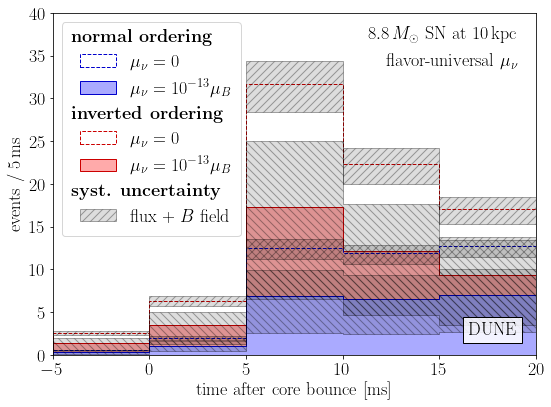

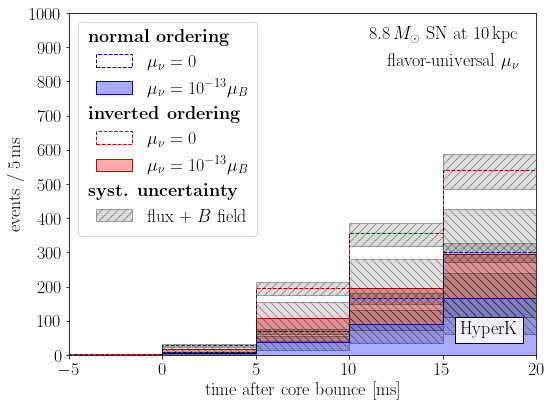

In [823]:
# plot event rates
def repeat_last(x):
    return x[list(range(len(x))) + [-1]]

exp_labels = { 'DUNE': 'DUNE', 'HK': 'HyperK' }
for exp in ['DUNE','HK']:
    fig, ax = plt.subplots()
    fig.set_size_inches(8,6)

    hist_nomu_NH = np.sum(rates_NH_0[exp,'nu','nomu'] + rates_NH_0[exp,'nubar','nomu'], axis=0)
    hist_mu_NH   = np.sum(rates_NH_0[exp,'nu','mu']   + rates_NH_0[exp,'nubar','mu'],   axis=0)
    hist_nomu_IH = np.sum(rates_IH_0[exp,'nu','nomu'] + rates_IH_0[exp,'nubar','nomu'], axis=0)
    hist_mu_IH   = np.sum(rates_IH_0[exp,'nu','mu']   + rates_IH_0[exp,'nubar','mu'],   axis=0)
    
    hist_nomu_NH_max = np.sum(rates_NH_max[exp,'nu','nomu'] + rates_NH_max[exp,'nubar','nomu'], axis=0)
    hist_mu_NH_max   = np.sum(rates_NH_max[exp,'nu','mu']   + rates_NH_max[exp,'nubar','mu'],   axis=0)
    hist_nomu_IH_max = np.sum(rates_IH_max[exp,'nu','nomu'] + rates_IH_max[exp,'nubar','nomu'], axis=0)
    hist_mu_IH_max   = np.sum(rates_IH_max[exp,'nu','mu']   + rates_IH_max[exp,'nubar','mu'],   axis=0)
    
    hist_nomu_NH_min = np.sum(rates_NH_min[exp,'nu','nomu'] + rates_NH_min[exp,'nubar','nomu'], axis=0)
    hist_mu_NH_min   = np.sum(rates_NH_min[exp,'nu','mu']   + rates_NH_min[exp,'nubar','mu'],   axis=0)
    hist_nomu_IH_min = np.sum(rates_IH_min[exp,'nu','nomu'] + rates_IH_min[exp,'nubar','nomu'], axis=0)
    hist_mu_IH_min   = np.sum(rates_IH_min[exp,'nu','mu']   + rates_IH_min[exp,'nubar','mu'],   axis=0)
    
    plot_nomu_IH = ax.hist(bin_centers*1e3, bins=binning*1e3, weights=hist_nomu_IH,
                           histtype='step', color='#cc0000', ls='--')[2][0]
    plot_err = \
    ax.fill_between(binning*1e3, repeat_last(hist_nomu_IH_min), repeat_last(hist_nomu_IH_max),
                    step='post', hatch='///', color='#00000022', ec='#00000055', zorder=2.5)

    plot_mu_IH   = ax.hist(bin_centers*1e3, bins=binning*1e3, weights=hist_mu_IH,
                           histtype='stepfilled', color='#ffaaaa', ec='#cc0000')[2][0]
    ax.fill_between(binning*1e3, repeat_last(hist_mu_IH_min),   repeat_last(hist_mu_IH_max),
                    step='post', hatch='\\\\\\', color='#00000022', ec='#00000055', zorder=2.5)

    plot_nomu_NH = ax.hist(bin_centers*1e3, bins=binning*1e3, weights=hist_nomu_NH,
                           histtype='step', color='#0000cc', ls='--')[2][0]
    ax.fill_between(binning*1e3, repeat_last(hist_nomu_NH_min), repeat_last(hist_nomu_NH_max),
                    step='post', hatch='///', color='#00000022', ec='#00000055', zorder=2.5)

    plot_mu_NH   = ax.hist(bin_centers*1e3, bins=binning*1e3, weights=hist_mu_NH,
                           histtype='stepfilled', color='#aaaaff', ec='#0000cc')[2][0]
    ax.fill_between(binning*1e3, repeat_last(hist_mu_NH_min),   repeat_last(hist_mu_NH_max),
                    step='post', hatch='\\\\\\', color='#00000022', ec='#00000055', zorder=2.5)

    legend_title_proxy = matplotlib.patches.Rectangle((0,0), 0, 0, color='w')
    leg = ax.legend([legend_title_proxy, plot_nomu_NH, plot_mu_NH,
                     legend_title_proxy, plot_nomu_IH, plot_mu_IH,
                     legend_title_proxy, plot_err],
                    ['\\bf normal ordering', '$\\mu_\\nu = 0$', '$\\mu_\\nu = 10^{-13} \\mu_B$',
                     '\\bf inverted ordering','$\\mu_\\nu = 0$', '$\\mu_\\nu = 10^{-13} \\mu_B$',
                     '\\bf syst. uncertainty', 'flux + $B$ field'], loc='upper left')
    for item, label in zip(leg.legendHandles, leg.texts): # move legend titles to the left
        item.set_x(30)
        label.set_position((30,0))
        if re.match('.*ordering|.*uncertainty', label._text):
            width = item.get_window_extent(fig.canvas.get_renderer()).width
            label.set_ha('left')
            label.set_position((-0.8*width,0))
#        if re.match('10.*', label._text):
#            item.set_y(-10)
#            label.set_position((30,-8))
    leg._legend_box.set_width(165.)
    leg._legend_box.set_height(200.)

    ax.set_xlim(-5, 20)
    ax.xaxis.set_ticks(np.arange(-5, 21, 5))
    if exp == 'HK':
        ax.set_ylim(0,400)
        ax.yaxis.set_ticks(np.arange(0, 1001, 100))
    elif exp == 'DUNE':
        ax.set_ylim(0, 40)
        ax.yaxis.set_ticks(np.arange(0, 41, 5))
    ax.set_ylabel('events / 5\,ms')
    ax.set_xlabel('time after core bounce [ms]')
#    ax.tick_params(axis='both', which='both', labelsize=12)
    plt.tight_layout()
    plt.annotate(exp_labels[exp], (0.96,0.05), xycoords='axes fraction',
                 ha='right', va='bottom',
                 bbox=dict(boxstyle='square', fc='#ffffffdd', ec='black'))
    plt.annotate(r'$8.8\,M_\odot$ SN at 10\,kpc',
                 (0.96,0.96), xycoords='axes fraction', ha='right', va='top')
    plt.annotate(r'flavor-universal $\mu_\nu$',
                 (0.96,0.88), xycoords='axes fraction', ha='right', va='top')
    plt.savefig('{:s}_1e-13mu_b_NO.pdf'.format(exp))
    plt.show()


### Supernova Neutrinos – $\chi^2$ Plots

In [179]:
# generate data for chi^2 plot
#mu_max    = 3.9e-13 * mu_b
mu_max    = 1.2e-12 * mu_b
#mu_table  = np.linspace(0, mu_max, 50)
mu_table  = np.logspace(-14, np.log10(mu_max/mu_b), 51) * mu_b
l0        = 0.01                     # nominal outer turbulence scale [kpc]
B0        = 2.                       # nominal B field strength [muG]
p         = neutrino_propagator(Bturb=B0, outer_scale=l0, mu_range=np.array([0] + list(mu_table[::2]) + [1e-11*mu_b]))
for mh in ['NH','IH']:
    for s, M in zip(['muonly','allflavors'], [M_mu_only, M_all_flavors]):
        print(mh, s)
        chi_DUNE = np.array([ p.propagate_sn_neutrinos(mu*M, mh=mh, a_norm=0., dn=True,  hk=False) for mu in mu_table ])
        chi_HK   = np.array([ p.propagate_sn_neutrinos(mu*M, mh=mh, a_norm=0., dn=False, hk=True)  for mu in mu_table ])
        np.savetxt('chi_{:s}_{:s}_DUNE.txt'.format(s, mh), np.array([mu_table, chi_DUNE]).T)
        np.savetxt('chi_{:s}_{:s}_HK.txt'.format(s, mh),   np.array([mu_table, chi_HK]).T)

NH muonly
NH allflavors
IH muonly
IH allflavors


In [152]:
# generate data for uncertainty bands
n_samples      = 10                                     # number of random B field configurations
l_table        = 10**rnd.uniform(-3,-1,size=n_samples)  # outer turbulence scale [kpc]
B_table        = rnd.normal(scale=5,   size=n_samples)  # magnetic field strength [muG]    
a_table        = rnd.normal(scale=0.1, size=n_samples)  # flux normalization bias
chi_table_DUNE = {}
chi_table_HK   = {}
mu_table  = np.linspace(0, mu_max, 20)
for l, B, a in zip(l_table, B_table, a_table):
    for mh in ['NH','IH']:
        for s, M in zip(['muonly','allflavors'], [M_mu_only, M_all_flavors]):
            print(mh,s)
            if not (mh,s) in chi_table_DUNE.keys():
                chi_table_DUNE[mh,s] = []
                chi_table_HK[mh,s]   = []
            p.generate_B_field_gal(Bturb=B, outer_scale=l, random_B_coh=True)
            chi_table_DUNE[mh,s].append( np.array([ p.propagate_sn_neutrinos(mu*M, mh=mh, a_norm=a, dn=True,  hk=False) for mu in mu_table ]))
            chi_table_HK[mh,s].append(   np.array([ p.propagate_sn_neutrinos(mu*M, mh=mh, a_norm=a, dn=False, hk=True)  for mu in mu_table ]))        
            
for mh in ['NH','IH']:
    for s, M in zip(['muonly','allflavors'], [M_mu_only, M_all_flavors]):
        np.savetxt('chi_{:s}_{:s}_DUNE-samples.txt'.format(s, mh), np.array([mu_table] + chi_table_DUNE[mh,s]).T)
        np.savetxt('chi_{:s}_{:s}_HK-samples.txt'  .format(s, mh), np.array([mu_table] + chi_table_HK[mh,s]).T)

NH muonly
NH allflavors
IH muonly
IH allflavors
NH muonly
NH allflavors
IH muonly
IH allflavors
NH muonly
NH allflavors
IH muonly
IH allflavors
NH muonly
NH allflavors
IH muonly
IH allflavors
NH muonly
NH allflavors
IH muonly
IH allflavors
NH muonly
NH allflavors
IH muonly
IH allflavors
NH muonly
NH allflavors
IH muonly
IH allflavors
NH muonly
NH allflavors
IH muonly
IH allflavors
NH muonly
NH allflavors
IH muonly
IH allflavors
NH muonly
NH allflavors
IH muonly
IH allflavors


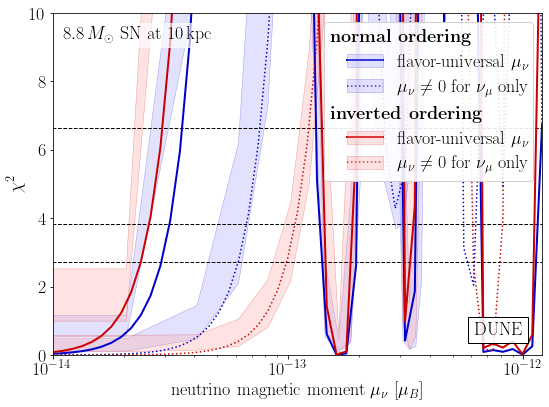

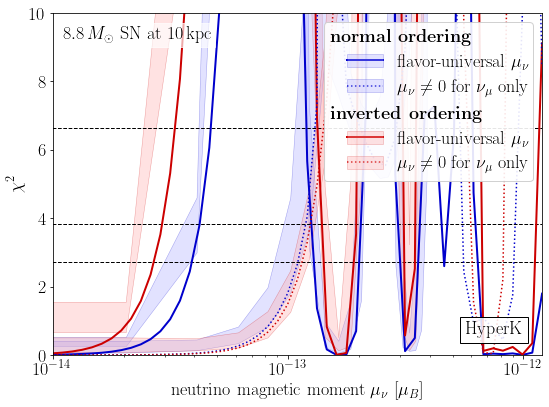

In [185]:
chi0      = {}
chi_table = {}
for mh in ['NH','IH']:
    for s, M in zip(['muonly','allflavors'], [M_mu_only, M_all_flavors]):
        for exp in ['DUNE','HK']:
            chi0[s,mh,exp]      = np.loadtxt('chi_{:s}_{:s}_{:s}.txt'.format(s, mh, exp))
            chi_table[s,mh,exp] = np.loadtxt('chi_{:s}_{:s}_{:s}-samples.txt'.format(s, mh, exp))
mu_table = chi0['allflavors','NH','DUNE'][:,0]

q = 0.5 * 0.317311  # quantile we are interested in for the error bands - this is for 1\sigma
exp_labels = { 'DUNE': 'DUNE', 'HK': 'HyperK' }
for exp in ['DUNE','HK']:
    fig, ax = plt.subplots()
    fig.set_size_inches(8,6)
    plot_allflavors_NH,     = ax.plot(mu_table/mu_b, chi0['allflavors','NH',exp][:,1], c='#0000cc', lw=2)
    plot_allflavors_err_NH  = ax.fill_between(chi_table['allflavors','NH',exp][:,0]/mu_b,
                                              np.quantile(chi_table['allflavors','NH',exp][:,1:], q,   axis=1),
                                              np.quantile(chi_table['allflavors','NH',exp][:,1:], 1-q, axis=1),
                                              color='#aaaaff55', ec='#0000cc55', lw=0.5)
    plot_allflavors_IH,     = ax.plot(mu_table/mu_b, chi0['allflavors','IH',exp][:,1], c='#cc0000', lw=2)
    plot_allflavors_err_IH  = ax.fill_between(chi_table['allflavors','IH',exp][:,0]/mu_b,
                                              np.quantile(chi_table['allflavors','IH',exp][:,1:], q,   axis=1),
                                              np.quantile(chi_table['allflavors','IH',exp][:,1:], 1-q, axis=1),
                                              color='#ffaaaa55', ec='#cc000055', lw=0.5)
    plot_muonly_NH,         = ax.plot(mu_table/mu_b, chi0['muonly','NH',exp][:,1],     c='#0000cc', ls=':')
    plot_muonly_err_NH      = ax.fill_between(chi_table['muonly','NH',exp][:,0]/mu_b,
                                              np.quantile(chi_table['muonly','NH',exp][:,1:], q,   axis=1),
                                              np.quantile(chi_table['muonly','NH',exp][:,1:], 1-q, axis=1),
                                              color='#aaaaff55', ec='#0000cc55', lw=0.5)
    plot_muonly_IH,         = ax.plot(mu_table/mu_b, chi0['muonly','IH',exp][:,1],     c='#cc0000', ls=':')
    plot_muonly_err_IH      = ax.fill_between(chi_table['muonly','IH',exp][:,0]/mu_b,
                                              np.quantile(chi_table['muonly','IH',exp][:,1:], q,   axis=1),
                                              np.quantile(chi_table['muonly','IH',exp][:,1:], 1-q, axis=1),
                                              color='#ffaaaa55', ec='#cc000055', lw=0.5)

    ax.set_xlim(min(mu_table)/mu_b, max(mu_table)/mu_b)
    ax.set_ylim(0, 10)
    ax.set_xscale('log')
#    ax.xaxis.set_ticks(np.arange(0, 1.001*mu_max/mu_b, .5e-13))
#    ax.yaxis.set_ticks(np.arange(0, 10.0001, 1))
#    ax.grid()
    ax.hlines(2.71, 0, mu_max/mu_b, color='k', ls='--', lw=1)
    ax.hlines(3.84, 0, mu_max/mu_b, color='k', ls='--', lw=1)
    ax.hlines(6.63, 0, mu_max/mu_b, color='k', ls='--', lw=1)
    ax.annotate(r'$95 \%$ C.L.', (0.05e-13, 3.95), bbox=dict(boxstyle='square', pad=0, fc='#ffffffdd', ec='none'))
    ax.annotate(r'$99 \%$ C.L.', (0.05e-13, 6.75), bbox=dict(boxstyle='square', pad=0, fc='#ffffffdd', ec='none'))
    ax.annotate(r'$90 \%$ C.L.', (0.05e-13, 2.85), bbox=dict(boxstyle='square', pad=0, fc='#ffffffdd', ec='none'))
    ax.set_ylabel(r'$\chi^2$')
    ax.set_xlabel(r'neutrino magnetic moment $\mu_\nu$ [$\mu_B$]')
    s = (r'Combined analysis of DUNE and Hyper-K setting $\\mu_e = \\mu_\\mu = \\mu_\\tau = \\mu_\\nu$')

    legend_title_proxy = matplotlib.patches.Rectangle((0,0), 0, 0, color='#00000000')
    leg = ax.legend([legend_title_proxy, (plot_allflavors_NH,plot_allflavors_err_NH), (plot_muonly_NH,plot_muonly_err_NH),
                     legend_title_proxy, (plot_allflavors_IH,plot_allflavors_err_IH), (plot_muonly_IH,plot_muonly_err_IH)],
                    [r'\bf normal ordering',  r'flavor-universal $\mu_\nu$', r'$\mu_\nu \neq 0$ for $\nu_\mu$ only',
                     r'\bf inverted ordering',r'flavor-universal $\mu_\nu$', r'$\mu_\nu \neq 0$ for $\nu_\mu$ only'],
                    handler_map={tuple: matplotlib.legend_handler.HandlerTuple()},
                    loc='upper right', framealpha=.9)
    
    def set_legend_handle_pos(packer, x):
        for p in packer.get_children():
            if isinstance(p, matplotlib.offsetbox.OffsetBox):
                set_legend_handle_pos(p, x)
            elif isinstance(p, matplotlib.patches.Rectangle):
                p.set_x(x)
            elif isinstance(p, matplotlib.lines.Line2D):
                p.set_xdata(np.array(p.get_xdata()) + 20)            
    set_legend_handle_pos(leg._legend_box, 20)
    for item, label in zip(leg.legendHandles, leg.texts): # move legend titles to the left
        if re.match('.*ordering', label._text):  # headings
            width = item.get_window_extent(fig.canvas.get_renderer()).width
            label.set_ha('left')
            label.set_position((-1.3*width,0))
        else:                                    # genuine legend entries
            label.set_position((20,0))
        leg._legend_box.set_width(195)
    plt.annotate(exp_labels[exp], (0.96,0.05), xycoords='axes fraction',
                 ha='right', va='bottom',
                 bbox=dict(boxstyle='square', fc='#ffffffdd', ec='black'))
    plt.annotate(r'$8.8\,M_\odot$ SN at 10\,kpc',
                 (0.02,0.96), xycoords='axes fraction', ha='left', va='top', backgroundcolor='#ffffffaa')
    plt.tight_layout()
#    plt.savefig('chi2-vs-mu-{:s}.pdf'.format(exp))
    plt.show()

### UHE Neutrinos – Flavor Ratios

In [2]:
# generate B field profiles
Nbs    = 50                   # number of independent random B field configurations
mu_min = 1e-16 * mu_b
mu_max = 4e-15 * mu_b         # maximal magnetic moment considered in this analysis
#mu_max = 1.2e-12 * mu_b         # maximal magnetic moment considered in this analysis
scale  = 'lin'
s      = 'single-source'      # pick one random B field profile for each point
#s      = 'multi-source'       # average over random B field profiles
    
p = neutrino_propagator(mu_range=[0])
p.generate_B_field_extragal(Nbs=Nbs)

/Users/jkopp/.pyenv/versions/3.8.3/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


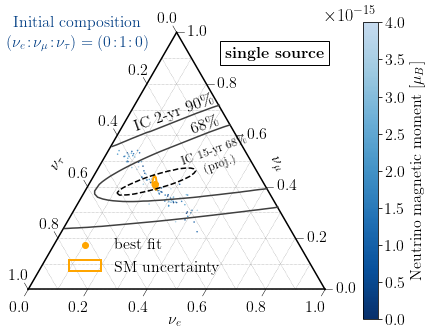

/Users/jkopp/.pyenv/versions/3.8.3/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


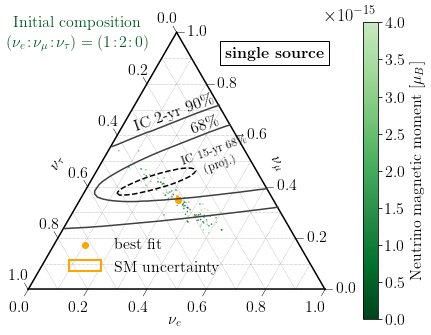

In [3]:
# IceCube limits on flavor ratios (from 1507.03991)
contour1 = np.concatenate((np.flip(np.loadtxt('data/contour.csv'), axis=0),
                           np.loadtxt('data/contour2.csv')[1:]), axis=0)
contour2 = np.loadtxt('data/contour3.csv')
contour3 = np.loadtxt('data/contour4.csv')

# IceCube projected limits (from 2008.04323)
contour8 = np.roll(np.loadtxt('data/8.csv'), 2, axis=1)
contour15 = np.roll(np.loadtxt('data/15.csv'), 2, axis=1)
contour1510 = np.roll(np.loadtxt('data/15+10.csv'), 2, axis=1)

# Parameters for the initial flux of astrophysical neutrinos (taken from 1507.03991)
phi_0 = 6.7
gamma = 2.5
E_min = 25 * TeV
E_max = 2.8 * PeV
h     = np.sqrt(3/4)    # height of ternary plot

def ratios(f_in, M_mu, m, Um):
    """Returns the final flavor ratios"""
    mu = np.linalg.multi_dot([Um.T, M_mu, Um])    # rotation to mass basis
    if s == 'multi-source':
        f_temp = np.array([ [np.dot(f_in, Um[:,j]**2) * p.P_osc_extragal(mu[j,j], idx=l)
                               for j in range(3)] for l in range(Nbs) ])
                    # FIXME why are the off-diagonal elements of mu not included?
        f = np.array([np.sum(np.dot(f_temp, Um[k,:]**2)) for k in range(3)])
        return f/np.sum(f)
    elif s == 'single-source':
        l      = np.random.randint(Nbs)
        f_temp = np.array([np.dot(f_in, Um[:,j]**2) * p.P_osc_extragal(mu[j,j], idx=l)
                               for j in range(3)])
                    # FIXME why are the off-diagonal elements of mu not included?
        f = np.array([np.dot(f_temp, Um[k,:]**2) for k in range(3)])
        return f/np.sum(f)

def three_to_two(f):
    """Converts coordinates from ternary plot into cartesian ones (three coordinates to two)"""
#    return [[(f[i][1] + 2*f[i][0])/2, f[i][1]*h] for i in range(len(f))]
    return np.array([(f[:,1] + 2*f[:,0])/2, f[:,1]*h]).T

fs = np.array([[0, 1, 0], [1, 2, 0]])  # flavor ratios at the source
N  = 1000                              # number of random parameter points

point_0    = np.array([0.31342, 0.34778, 0.33880])

# generate random parameter points
th12_table = np.random.normal(loc=theta12, scale=d_theta12, size=N)
th13_table = np.random.normal(loc=theta13, scale=d_theta13, size=N)
th23_table = np.random.normal(loc=theta23, scale=d_theta23, size=N)
U_table    = np.array([PMNS(th12, th13, th23)[:3,:3]
                 for th12, th13, th23 in zip(th12_table, th13_table, th23_table)])
if scale == 'lin':
    mu_table = np.random.uniform(0, mu_max, size=N)
elif scale == 'log':
    mu_table = 10**np.random.uniform(np.log10(mu_min), np.log10(mu_max), size=N)
else:
    raise ValueError('invalid option: scale={:s}'.format(scale))

# propagate neutrinos for the generated points
# if stored points exist, use them to save time
if os.path.exists("data/flavor-ratio-{:s}-points_10.dat".format(s)):
    for j, points_0, points_sm, points_v, in zip(range(2),
                                                 [points_10,  points_20],
                                                 [points_1sm, points_2sm],
                                                 [points_1v,  points_2v]):
        points_0  = np.loadtxt("data/flavor-ratio-{:s}-points_{:d}0.dat".format(s, j))
        points_sm = np.loadtxt("data/flavor-ratio-{:s}-points_{:d}sm.dat".format(s, j))
        points_v  = np.loadtxt("data/flavor-ratio-{:s}-points_{:d}v.dat".format(s, j))

else:
    # flavor ratios at zero magnetic moment for the nominal values of the oscillation parameters
    U          = U = PMNS(theta12, theta13, theta23)[:3,:3]
    points_10  = ratios(fs[0], np.zeros((3,3)), m_nh, U)
    points_20  = ratios(fs[1], np.zeros((3,3)), m_nh, U)

    # flavor ratios at zero magnetic moment, but including oscillation parameter uncertainties
    points_1sm = np.array([ ratios(fs[0], 0*M_mu_only, m_nh, U) for mu, U in zip(mu_table, U_table) ])
    points_2sm = np.array([ ratios(fs[1], 0*M_mu_only, m_nh, U) for mu, U in zip(mu_table, U_table) ])

    # flavor ratios for varying magnetic moment and oscillation parameters
    points_1v  = np.array([ ratios(fs[0], mu*M_mu_only, m_nh, U) for mu, U in zip(mu_table, U_table) ])
    points_2v  = np.array([ ratios(fs[1], mu*M_mu_only, m_nh, U) for mu, U in zip(mu_table, U_table) ])

    for j, points_0, points_sm, points_v, in zip(range(2),
                                                 [points_10,  points_20],
                                                 [points_1sm, points_2sm],
                                                 [points_1v,  points_2v]):
        np.savetxt("data/flavor-ratio-{:s}-points_{:d}0.dat".format(s, j), points_0)
        np.savetxt("data/flavor-ratio-{:s}-points_{:d}sm.dat".format(s, j), points_sm)
        np.savetxt("data/flavor-ratio-{:s}-points_{:d}v.dat".format(s, j), points_v)
        
# color maps
blues  = plt.get_cmap('Blues')
greens = plt.get_cmap('Greens')
grey   = plt.get_cmap('Greys')
cmbl   = colors.ListedColormap(blues(np.linspace(1.0, 0.25, 256)))
cmgr   = colors.ListedColormap(greens(np.linspace(1.0, 0.25, 256)))

for j, points_0, points_sm, points_v, cm in zip(range(2),
                                                [points_10,  points_20],
                                                [points_1sm, points_2sm],
                                                [points_1v,  points_2v],
                                                [cmbl, cmgr]):
    fig, tax = ternary.figure()
    fig.set_size_inches(7,5)
    ax = tax.get_axes()
    tax.gridlines(multiple=0.1, color='grey')
    tax.boundary()
    tax.set_background_color('white')
    tax.bottom_axis_label("$\\nu_e$", offset=0.03, fontsize=16)
    tax.right_axis_label("$\\nu_{\\mu}$", offset=0.1, fontsize=16)
    tax.left_axis_label("$\\nu_{\\tau}$", offset=0.16, fontsize=16)
    ax.axis('off')
    ax.set_aspect(1)
    tax.ticks(axis='lbr', linewidth=0.5, multiple=0.2, tick_formats="%.1f", offset=0.025, fontsize=16)

    plt1, = ax.plot(np.transpose(three_to_two(contour1))[0], np.transpose(three_to_two(contour1))[1],
                    color=grey(0.8))
    tax.plot(contour2, color=grey(0.8))
    tax.plot(contour3, color=grey(0.8))
#     plt8, = ax.plot(np.transpose(three_to_two(contour8+points_10-point_0))[0],
#                     np.transpose(three_to_two(contour8+points_10-point_0))[1], label='IceCube 8 yr $(68 \%)$')
    plt15, = ax.plot(np.transpose(three_to_two(contour15+points_10-point_0))[0],
                     np.transpose(three_to_two(contour15+points_10-point_0))[1],
                     color='black', ls='--') # label='IceCube 15 yr $(68 \%)$')
#     plt25, = ax.plot(np.transpose(three_to_two(contour1510+points_10-point_0))[0],
#                      np.transpose(three_to_two(contour1510+points_10-point_0))[1],
#                      color='black', ls=':') # label='IceCube 15 yr + Gen2 10yr $(68 \%)$'
    ax.annotate("68\%", (0.54, 0.525), rotation=20, size=16)
    ax.annotate("IC 2-yr 90\%", (0.35, 0.535), rotation=20, size=16)
    ax.annotate("\parbox{3cm}{\centering IC 15-yr 68\%\\\\(proj.)}", (0.51, 0.40), rotation=20, size=12)

    # plot nominal point (mu=0, best fit oscillation parameters)
    plt_bfp = tax.scatter([points_0], color='orange', zorder=2, label='best fit')
    
    # plot uncertainty contour for mu=0
    alpha_shape = alphashape.alphashape(three_to_two(points_sm), 0.)
    plt_sm  = descartes.PolygonPatch(alpha_shape, alpha=1, fill=False,
                                     lw=2, color='orange', label=r'SM uncertainty')
    ax.add_patch(plt_sm)
    
    # plot points with varying mu, theta
    if scale == 'lin':
        tax.scatter(points_v, marker='.', color=cm(mu_table/mu_max), s=1)
        norm = colors.Normalize(0.0, mu_max/mu_b)
    elif scale == 'log':
        tax.scatter(points_v, marker='.', color=cm( (np.log10(mu_table) - np.log10(mu_min))
                                                  / (np.log10(mu_max) - np.log10(mu_min)) ), s=1)
        norm = colors.LogNorm(mu_min/mu_b, mu_max/mu_b)
    else:
        raise ValueError('invalid option: scale={:s}'.format(scale))

    # draw colorbar legend
    cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cm), ax=ax)
    cbar.ax.tick_params(labelsize=16)
    cbar.set_label('Neutrino magnetic moment [$\\mu_B$]', size=16)

    #leg = ax.legend(handles=[plt1, plt8, plt15, plt25], loc=(0.15, 0.1), frameon=False)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=reversed(handles), labels=reversed(labels),
                    loc=(0.15, 0.13), fontsize=16, frameon=False, facecolor='#ffffffbb', edgecolor='#ffffff00')
    ax.annotate(r'\parbox{6cm}{\centering Initial composition\\$(\nu_e\!:\!\nu_\mu\!:\!\nu_\tau) = '
               + '(%d\!:\!%d\!:\!%d)$}' % (fs[j][0], fs[j][1], fs[j][2]),
                (0.2,1.02), xycoords='axes fraction', ha='center', va='top', fontsize=16, color=cm(0.1))
    if s == 'single-source':
        ax.annotate(r'\bf single source', (0.8, 0.92), xycoords='axes fraction', ha='center', va='top',
                    fontsize=16, bbox=dict(boxstyle='square', fc='#ffffffdd', ec='black'))
    elif s == 'multi-source':
        ax.annotate(r'\bf multiple sources', (0.8, 0.92), xycoords='axes fraction', ha='center', va='top',
                    fontsize=16, bbox=dict(boxstyle='square', fc='#ffffffdd', ec='black'))
    tax._redraw_labels()
    plt.tight_layout()
    #plt.savefig("flavor_ratios_averaging_{:d}.pdf".format(j))
    plt.show()

/Users/jkopp/.pyenv/versions/3.8.3/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


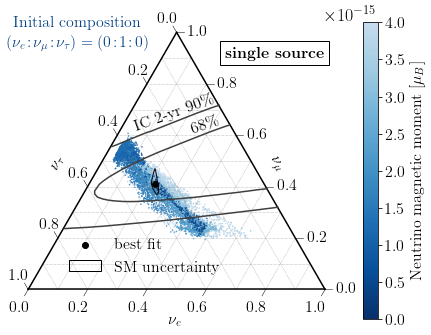

/Users/jkopp/.pyenv/versions/3.8.3/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


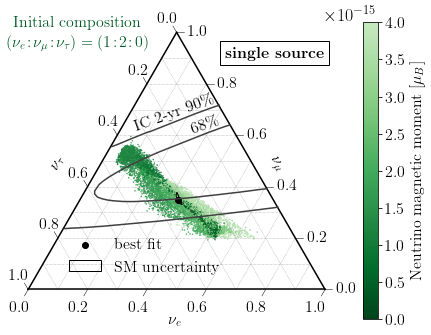

In [73]:
# linear scale - small mu range - Nm=200

/Users/jkopp/.pyenv/versions/3.8.3/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


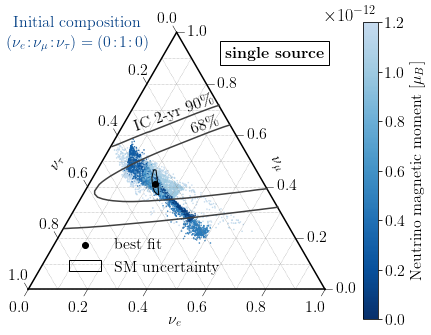

/Users/jkopp/.pyenv/versions/3.8.3/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


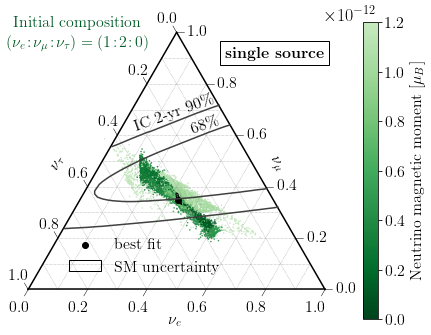

In [19]:
# linear scale - large mu range

/Users/jkopp/.pyenv/versions/3.8.3/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


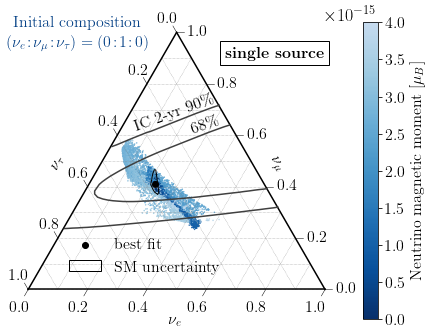

/Users/jkopp/.pyenv/versions/3.8.3/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


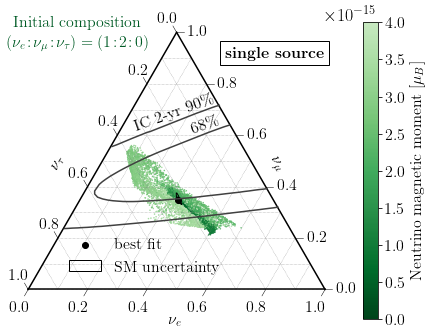

In [220]:
# linear scale - small mu range - Nm=20